# Multi-resolution deconvolution of spatial transcriptomics

In this tutorial, we through the steps of applying DestVI for deconvolution of 10x Visium spatial transcriptomics profiles using an accompanying single-cell RNA sequencing data. 

**Background:**

Spatial transcriptomics technologies are currently limited, because their resolution is limited to niches (spots) of sizes well beyond that of a single cell. Although several pipelines proposed joint analysis with single-cell RNA-sequencing (scRNA-seq) to alleviate this problem they are limited to a discrete view of cell type proportion inside every spot. This limitation becomes critical in the common case where, even within a cell type, there is a continuum of cell states. We present *Deconvolution of Spatial Transcriptomics profiles using Variational Inference (DestVI)*, a probabilistic method for multi-resolution analysis for spatial transcriptomics that explicitly models continuous variation within cell types.

**Plan for this tutorial:**

1. Loading the data
2. Training the single-cell model (scLVM) to learn a basis of gene expression on the scRNA-seq data
3. Training the spatial model (stLVM) to perform the deconvolution
4. Visualize the learned cell type proportions
5. Run our automated pipeline
6. Dig into the intra cell type information 
7. Run cell-type specific differential expression

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install
install(branch='master')
!pip install --quiet git+https://github.com/yoseflab/destvi_utils.git@main

     |████████████████████████████████| 201 kB 4.2 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 
INFO     scvi-colab: Installing scvi-tools.                                                  
INFO     scvi-colab: Install successful. Testing import.                                     


Global seed set to 0


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 525 kB 4.3 MB/s 
     |████████████████████████████████| 1.0 MB 27.0 MB/s 
     |████████████████████████████████| 47 kB 4.0 MB/s 
     |████████████████████████████████| 47 kB 4.2 MB/s 
     |████████████████████████████████| 144 kB 50.2 MB/s 
     |████████████████████████████████| 5.8 MB 27.5 MB/s 
     |████████████████████████████████| 251 kB 53.9 MB/s 
     |████████████████████████████████| 127 kB 53.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Let's download our data from a comparative study of murine lymph nodes, comparing wild-type with a stimulation after injection of a mycobacteria. We have at disposal a 10x Visium dataset as well as a matching scRNA-seq dataset from the same tissue.

In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

from scvi.model import CondSCVI, DestVI

sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [3]:
url1 = "https://github.com/romain-lopez/DestVI-reproducibility/blob/master/lymph_node/deconvolution/ST-LN-compressed.h5ad?raw=true"
url2 = "https://github.com/romain-lopez/DestVI-reproducibility/blob/master/lymph_node/deconvolution/scRNA-LN-compressed.h5ad?raw=true"
out1 = "data/ST-LN-compressed.h5ad"
out2 = "data/scRNA-LN-compressed.h5ad"

##1. Data loading & processing

First, let's load the single-cell data. We profiled immune cells from murine lymph nodes with 10x Chromium, as a control / case study to study the immune response to exposure to a mycobacteria (refer to our paper for more info). We provide the preprocessed data from our reproducibility repository: it contains the raw counts (DestVI always takes raw counts as input).

In [4]:
sc_adata = sc.read(out2, backup_url=url2)

  0%|          | 0.00/76.0M [00:00<?, ?B/s]

We clustered the single-cell data by major immune cell types. DestVI can resolve beyond discrete clusters, but need to work with an existing level of clustering. A rule of thumb to keep in mind while clsutering is that DestVI assumes only a single state from each cell type exists in each spot. For example, resting and inflammed monocytes cannot co-exist in one unique spot according to our assumption. Users may cluster their data so that this modeling assumption is as accurate as possible. 

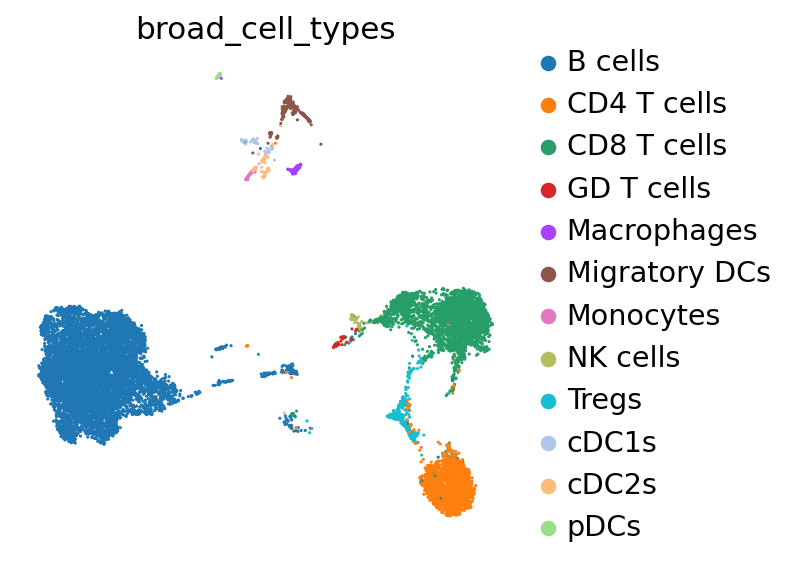

In [5]:
sc.pl.umap(sc_adata, color="broad_cell_types")

In [6]:
# let us filter some genes
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=G,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

Now, let's load the spatial data and choose a common gene subset. Users will note that having a common gene set is a prerequisite of the method.

In [7]:
st_adata = sc.read(out1, backup_url=url1)

  0%|          | 0.00/12.8M [00:00<?, ?B/s]

In [8]:
st_adata.layers["counts"] = st_adata.X.copy()
st_adata.obsm['spatial'] = st_adata.obsm['location']

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

In [9]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

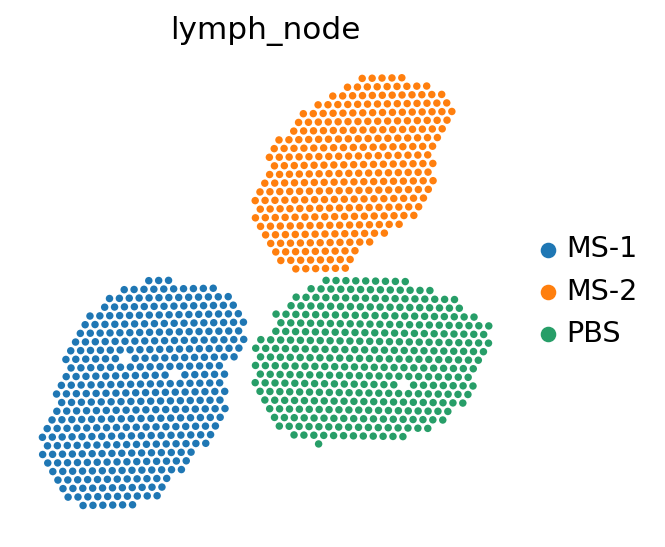

In [10]:
sc.pl.spatial(st_adata, color="lymph_node", spot_size=130)

## 2. Fit the scLVM

The single-cell Latent Variable Model (scLVM) models the single-cell RNA sequencing data.

In [11]:
CondSCVI.setup_anndata(sc_adata, layer="counts", labels_key="broad_cell_types")

As a first step, we embed our data using a cell type conditional VAE. We pass the layer containing the raw counts and the labels key. We train this model without reweighting the loss by the cell type abundance. Training will take around 5 minutes in a Colab GPU session.


In [12]:
sc_model = CondSCVI(sc_adata, weight_obs=False)
sc_model.view_anndata_setup()

In [13]:
sc_model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [08:47<00:00,  1.76s/it, loss=814, v_num=1]


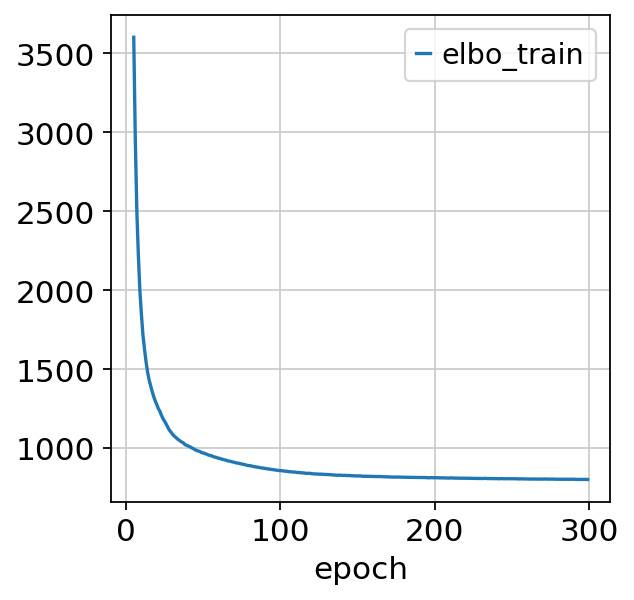

In [36]:
sc_model.history["elbo_train"].iloc[5:].plot()
plt.show()

Note that model converges quickly. Over experimentation with the model drastically reducing the number of epochs leads to decreased performance and performance deteriorates as max_epochs<200.

## 4. Deconvolution with stLVM

As a second step, we train our deconvolution model: spatial transcriptomics Latent Variable Model (stLVM).
We setup the DestVI model using the `counts` layer in `st_adata` that contains the raw counts. We then pass the trained `CondSCVI` model and generate a new model based on `st_adata` and `sc_model` using `DestVI.from_rna_model`.

The decoder network architecture will be generated from `sc_model`. Two neural networks are initiated for cell type proportions and gamma value amortization. Training will take around 5 minutes in a Colab GPU session.

Potential adaptations of `DestVI.from_rna_model` are:
1.   increasing `vamp_prior_p` leads to less gradual changes in gamma values
2.   more discretized values. Increasing `l1_sparsity` will lead to sparser results for cell type proportions.
3. Although we recommend using similar sequencing technology for both assays, consider changing `beta_weighting_prior` otherwise.

Technical Note: During inference, we adopt a variational mixture of posterior as a prior to enforce gamma values in stLVM match scLVM (see details in original publication). This empirical prior is based on cell type specific subclustering (using k-means to find `vamp_prior_p` clusters) of the posterior distribution in latent space for every cell. 

In [15]:
DestVI.setup_anndata(st_adata, layer="counts")

In [114]:
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.view_anndata_setup()

In [115]:
st_model.train(max_epochs=2500)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 2500/2500: 100%|██████████| 2500/2500 [08:44<00:00,  4.76it/s, loss=1.94e+06, v_num=1]


Note that model converges quickly. Over experimentation with the model drastically reducing the number of epochs leads to decreased performance and we advocate against max_epochs<1000.

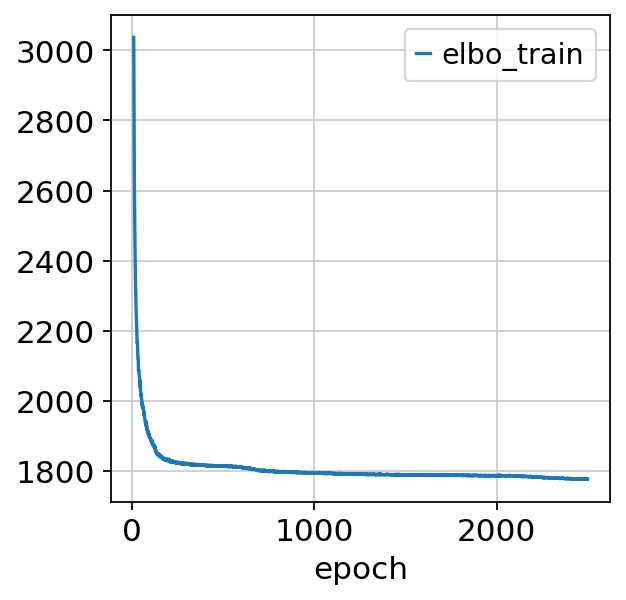

In [116]:
st_model.history["elbo_train"].iloc[10:].plot()
plt.show()

The output of DestVI has two resolution. At the broader resolution, DestVI returns the cell type proportion in every spot. At the more granular resolution, DestVI can impute cell type specific gene expression in every spot. 

## 5. Cell type proportions


We extract the computed cell type proportions and display them in spatial embedding. These values are directly calculated by normalized the spot-level parameters from the stLVM model.

In [117]:
st_adata.obsm["proportions"] = st_model.get_proportions()

In [118]:
st_adata.obsm["proportions"].head(5)

,B cells,CD4 T cells,CD8 T cells,GD T cells,Macrophages,Migratory DCs,Monocytes,NK cells,Tregs,cDC1s,cDC2s,pDCs
AAACCGGGTAGGTACC-1-0,0.616472,0.019967,0.056003,0.002724,0.029665,0.041392,0.054665,0.002381,0.051558,0.073302,0.018830,0.033042
AAACCTCATGAAGTTG-1-0,0.573150,0.040745,0.053432,0.005539,0.023573,0.066538,0.020201,0.001053,0.054607,0.078683,0.065538,0.016940
AAAGACTGGGCGCTTT-1-0,0.575212,0.046111,0.087140,0.020666,0.019213,0.058907,0.024388,0.000639,0.049040,0.062274,0.052940,0.003470
AAAGGGCAGCTTGAAT-1-0,0.073539,0.155957,0.364163,0.009091,0.007241,0.080266,0.062239,0.002845,0.160965,0.051779,0.026558,0.005357
AAAGTCGACCCTCAGT-1-0,0.750688,0.028041,0.008557,0.004058,0.027970,0.033851,0.024797,0.001699,0.021806,0.051286,0.037029,0.010215


In [119]:
ct_list = ["B cells", "CD8 T cells", "Monocytes"]
for ct in ct_list:
  data = st_adata.obsm["proportions"][ct].values
  st_adata.obs[ct] = np.clip(data, 0, np.quantile(data, 0.99))

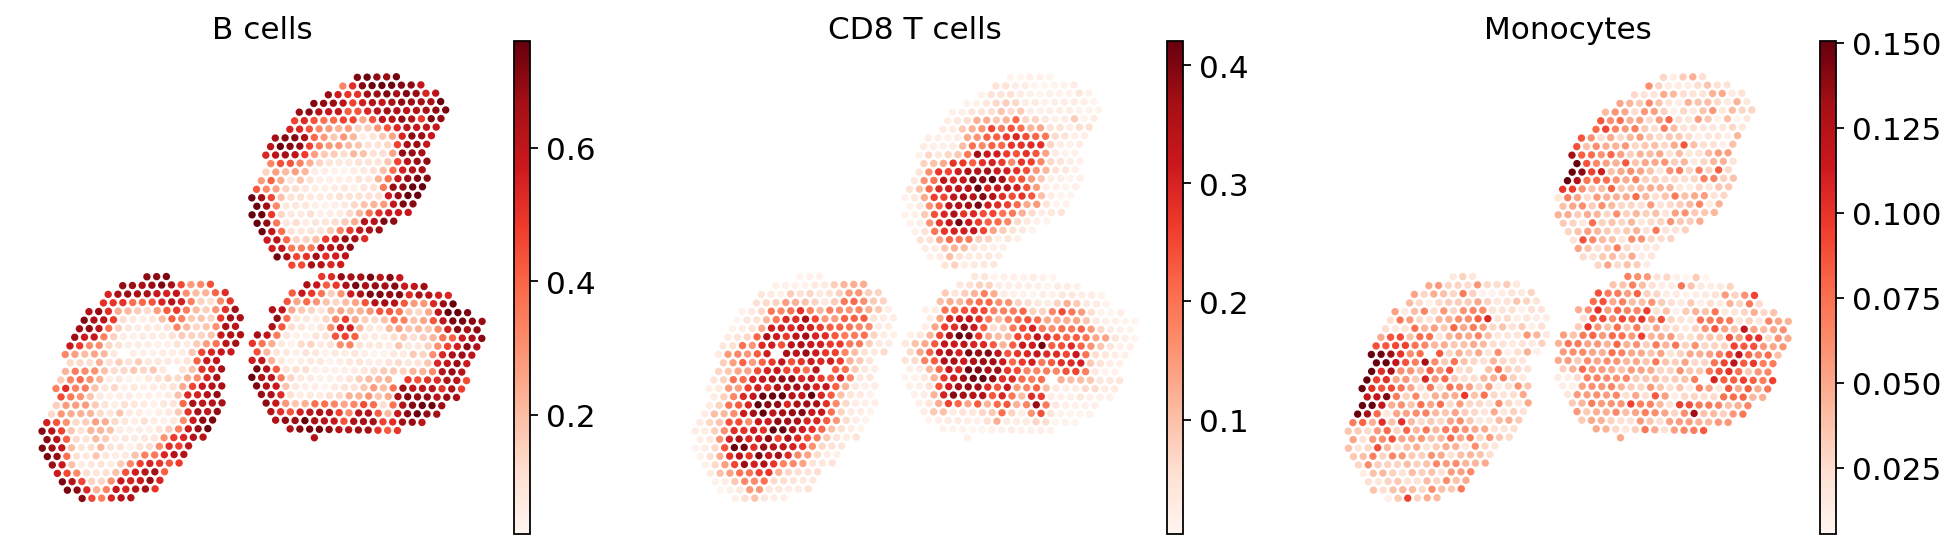

In [120]:
sc.pl.spatial(st_adata, color=ct_list, cmap='Reds', spot_size=130)

Because the inference of cell type specific gene expression is prone to error when the cell type is not present in a spot, and because the cell type proportion values estimated by stLVM are not sparse, we provide an automated way of thresholding them. For follow-up analysis we recommend checking these threshold values and adjust them for each cell type.

This part of the software is not directly available in scvi-tools, but instead in the util package `destvi_utils` (installable from GitHub; refer to the top of this tutorial).

In [121]:
import destvi_utils

100%|██████████| 100/100 [00:00<00:00, 11115.45it/s]


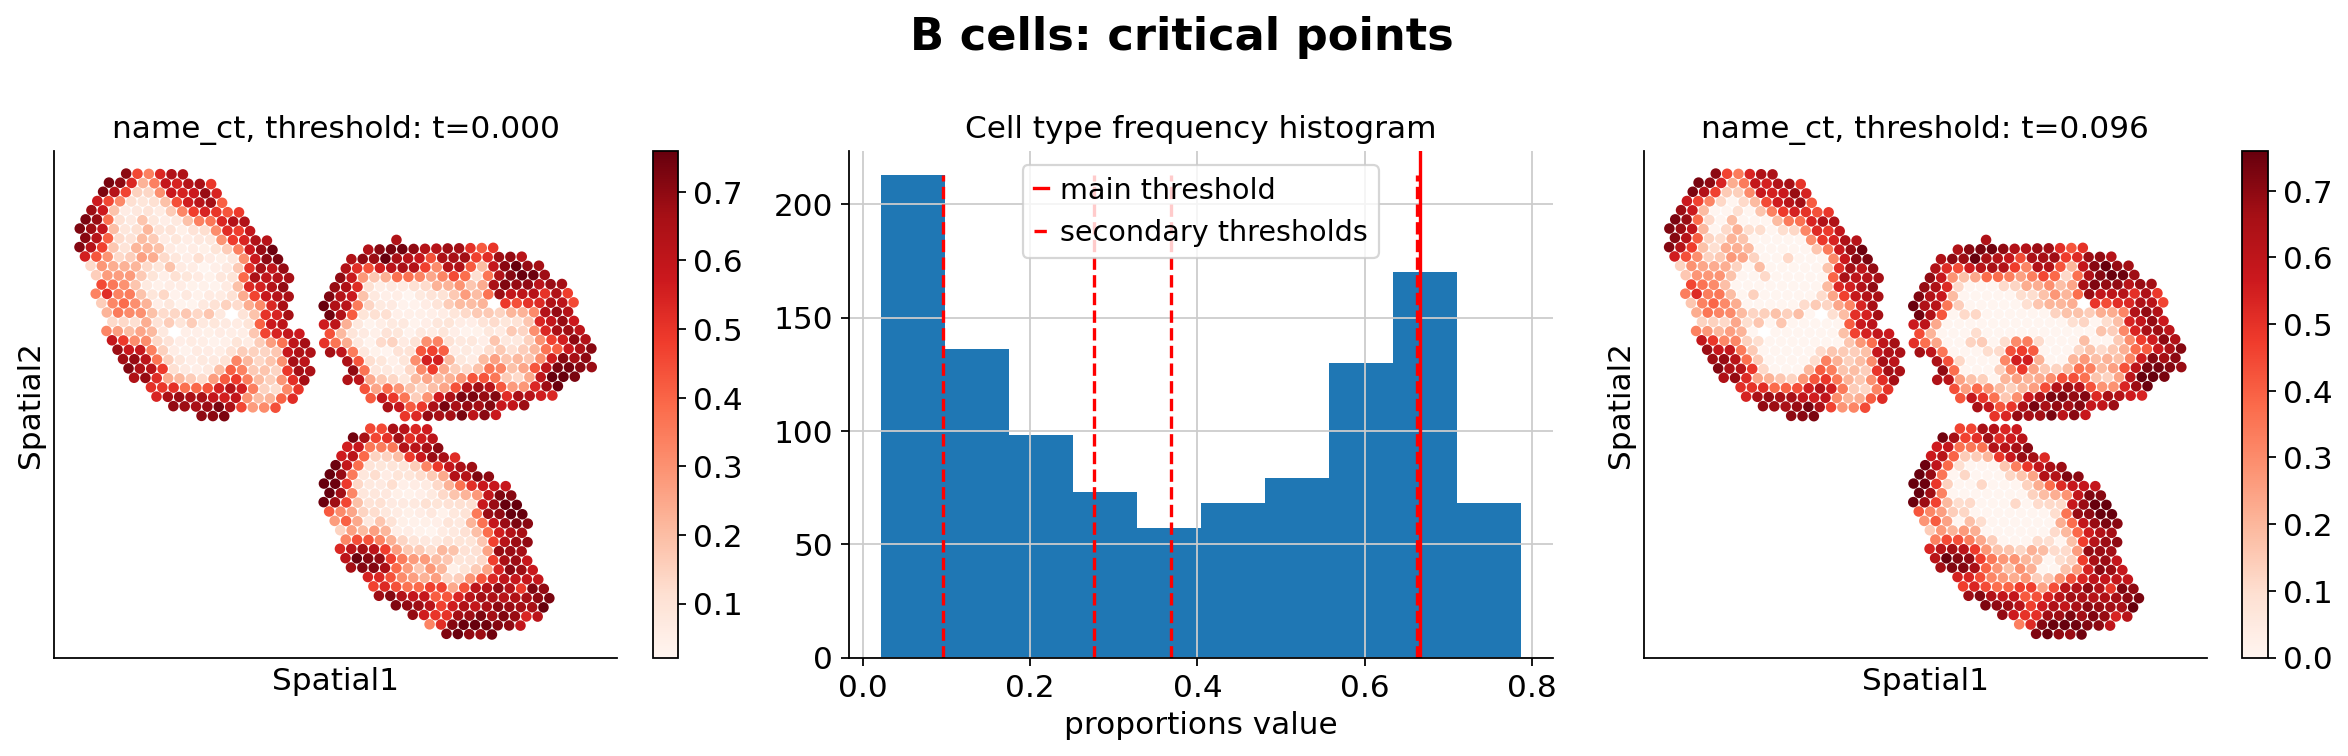

100%|██████████| 100/100 [00:00<00:00, 6097.35it/s]


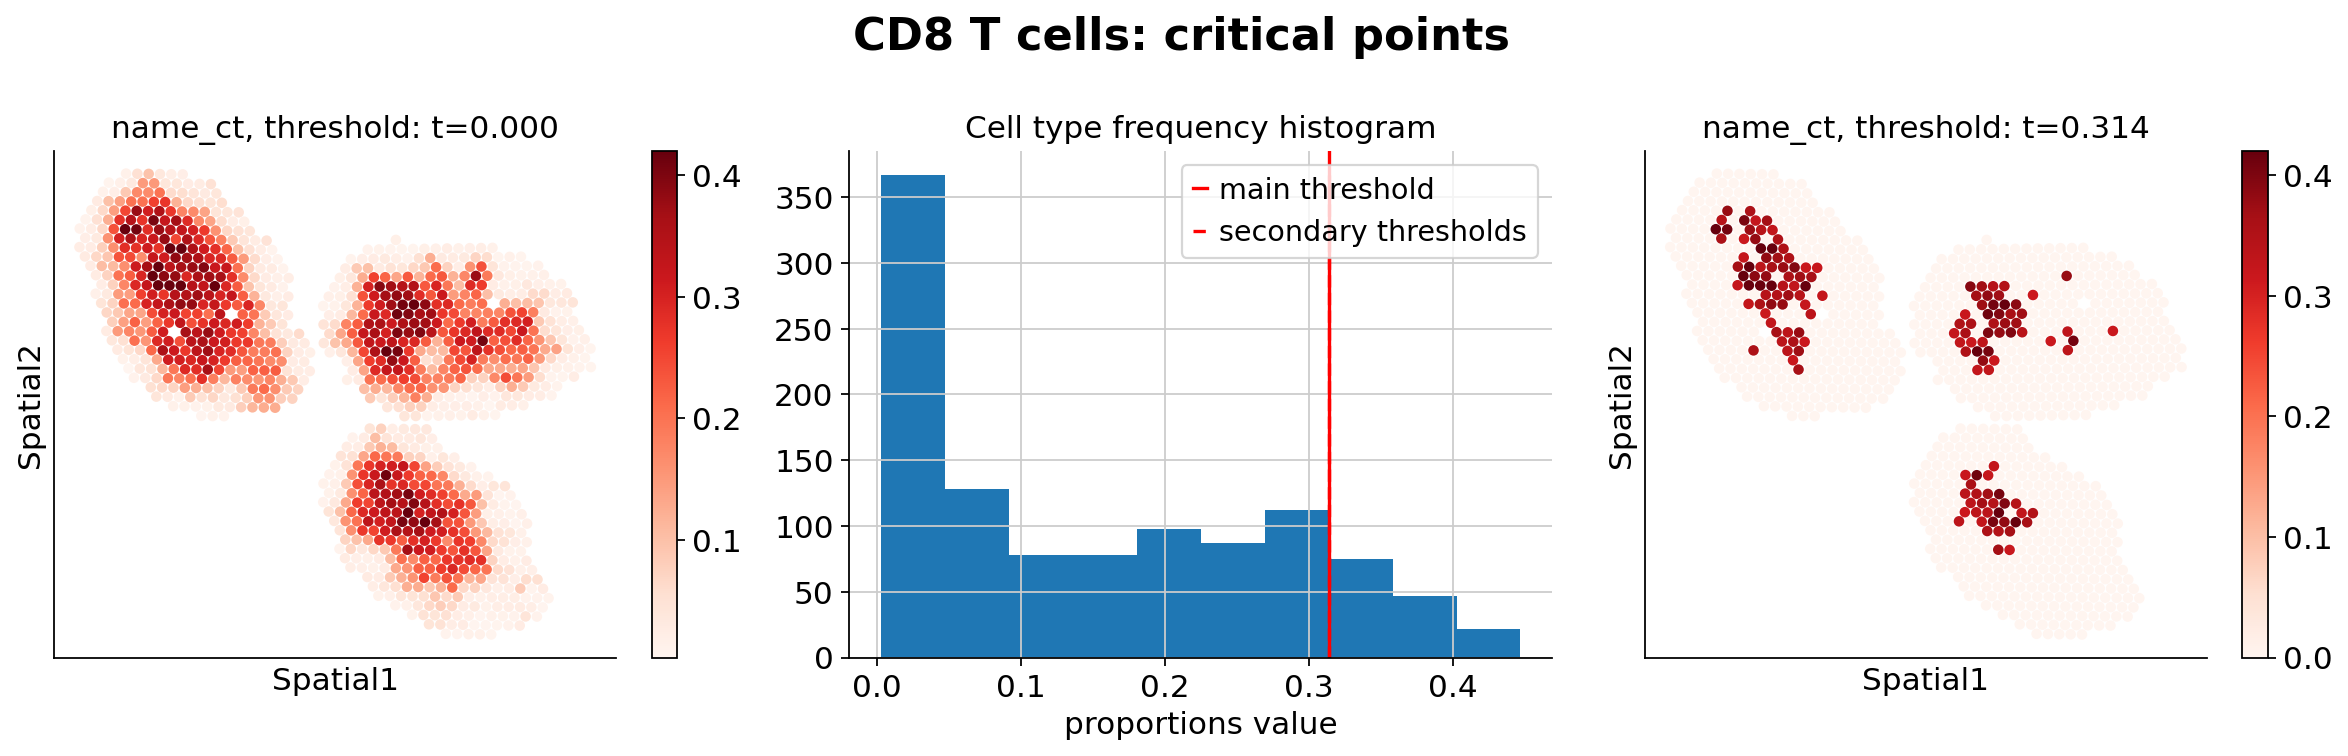

100%|██████████| 100/100 [00:00<00:00, 6136.06it/s]


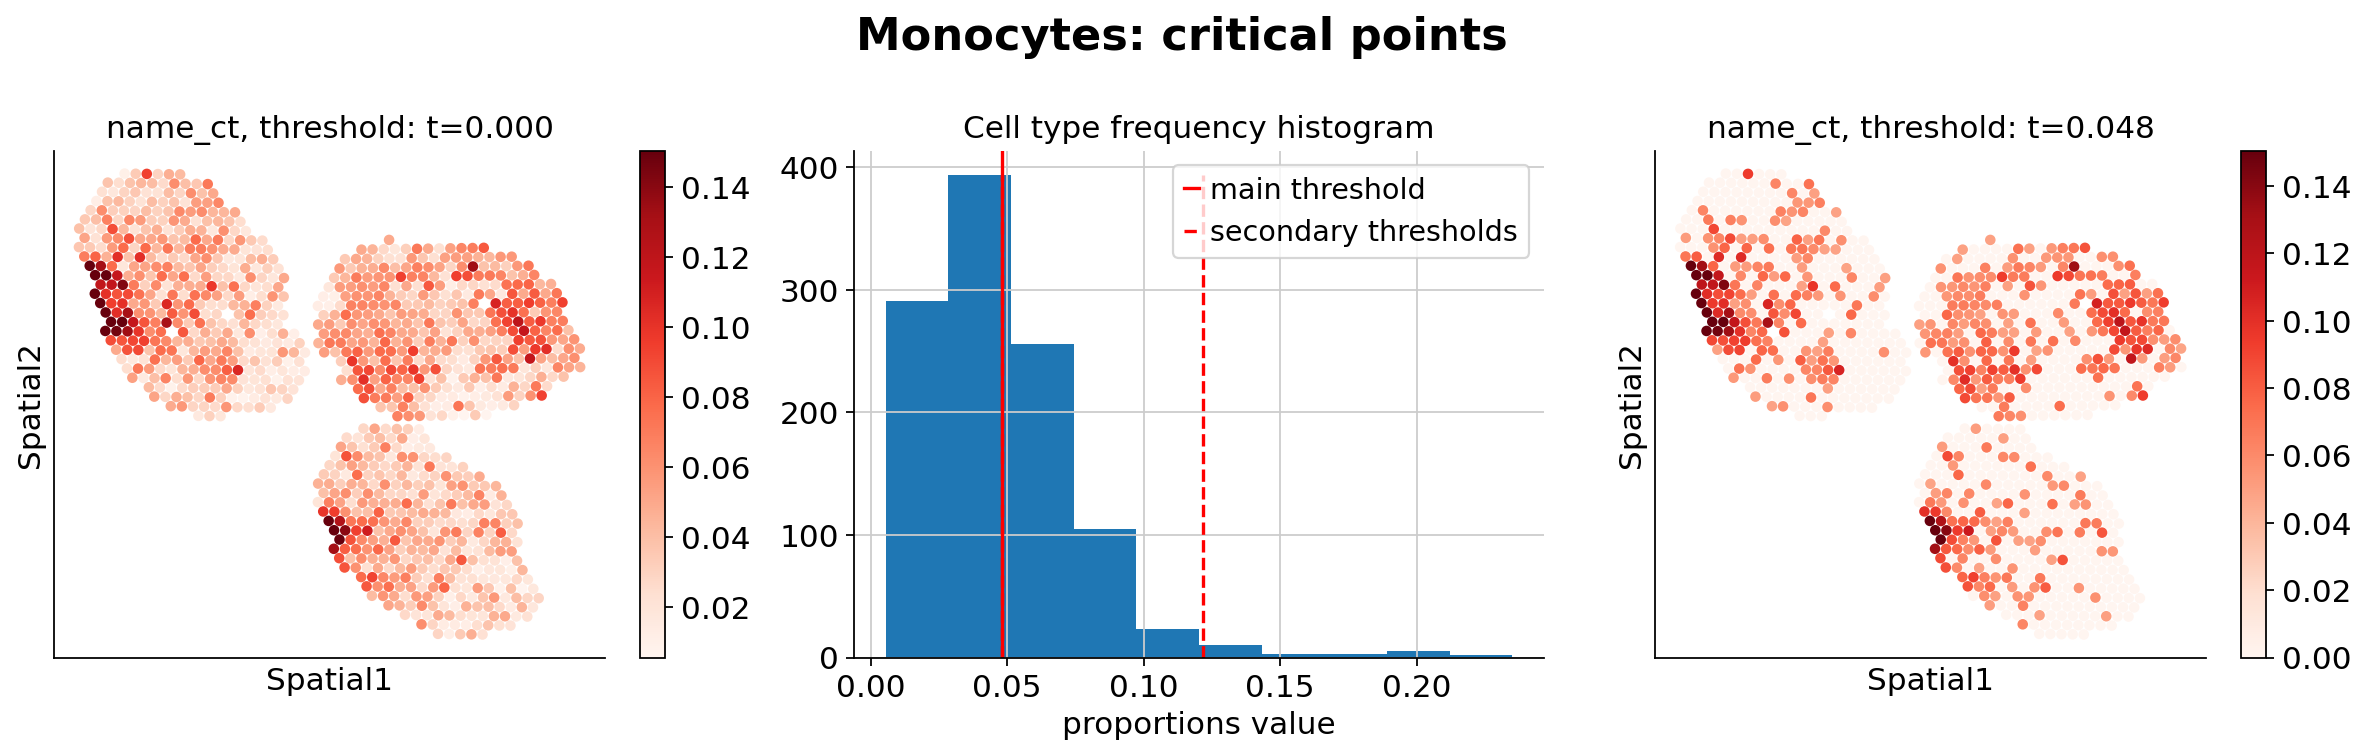

In [122]:
ct_thresholds = destvi_utils.automatic_proportion_threshold(st_adata, ct_list=ct_list, kind_threshold='secondary')

In terms of cell type location, we observe a strong compartimentalization of the cell types in the lymph node (B cells / T cells), as expected. We also observe a differential localization of the monocytes (refer to the paper for further details).

## 6. Intra cell type information

At the heart of DestVI is a multitude of latent variables (5 per cell type per spots). We refer to them as "gamma", and we may manually examine them for downstream analysis

In [123]:
# more globally, the values of the gamma are all summarized in this dictionary of data frames
for ct, g in st_model.get_gamma().items():
  st_adata.obsm["{}_gamma".format(ct)] = g

In [124]:
st_adata.obsm["B cells_gamma"].head(5)

,0,1,2,3,4
AAACCGGGTAGGTACC-1-0,-0.355600,-0.248185,0.120208,-0.487127,0.505696
AAACCTCATGAAGTTG-1-0,-0.180581,0.501296,-0.370263,-0.646926,0.673778
AAAGACTGGGCGCTTT-1-0,-1.459096,0.032320,-1.594361,0.266110,0.615625
AAAGGGCAGCTTGAAT-1-0,-0.258851,0.748279,-0.150788,0.111421,0.292578
AAAGTCGACCCTCAGT-1-0,0.458364,-0.767840,-0.199212,-0.076236,-0.280005


Because those values may be hard to examine manually for end-users, we presented in the manuscript several methods for prioritizing the study of different cell types (based on spatially-weighted PCA and Hotspot). Below we provide the result of our automated pipeline with the spatially-weighted PCA.

More precisely, for de novo detection of spatial patterns, we study the gamma space and use a spatially-informed PCA to find the spatial axis of variation in this gamma space. We use EnrichR to functionally annotate these genes. In particular, we recover enrichment of IFN genes across monocytes as well as B cells

The function `explore_gamma_space` operates as follow, for each cell type individually:
1.   Select all the spots with proportions beyond the magnitude threshold,
2.   Calculate the spot-specific cell-type-specific embeddings gamma,
3.   Calculate the first two principal vectors of those gamma values, weighted by the spatial coordinates,
4.   Project all the embeddings (considered spots, and single-cell profiles) onto this 2D space,
5.  Map each spot (or cell) to a specific color via its 2d coordinate, using the `cmap2d` package
6.   Plot (A) the color of every spot in spatial coordinates (B) the color of every spot in sPC space (C) the color of every single cell in sPC space
7. Calculate genes enriched in each direction and group into pathways with `EnrichR`



/usr/local/lib/python3.7/dist-packages/cmap2d/util.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  bary_coords = la.lstsq(self._a,b)[0]



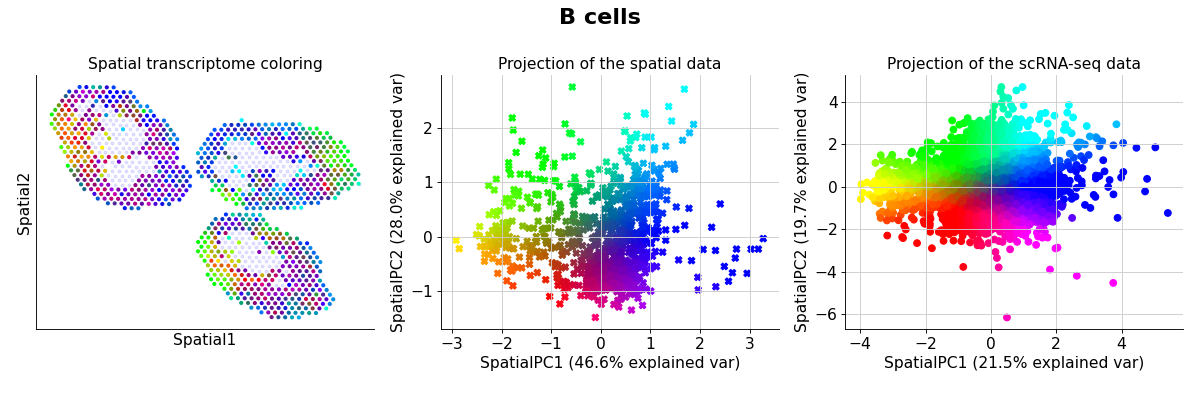
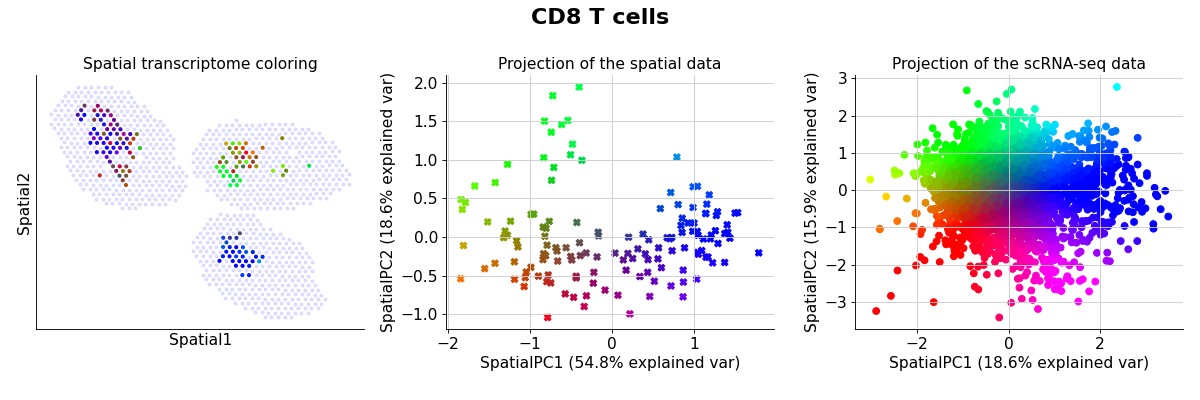
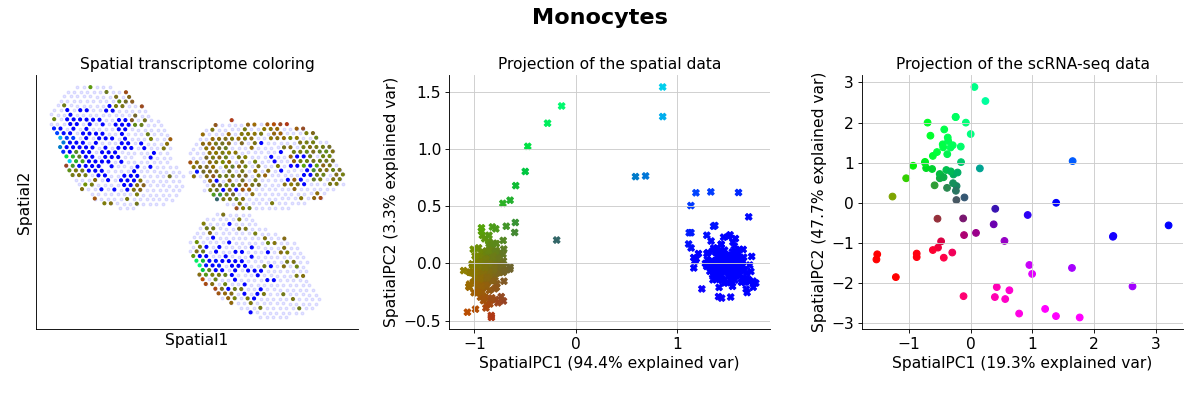

In [125]:
destvi_utils.explore_gamma_space(st_model, sc_model, ct_list=ct_list, ct_thresholds=ct_thresholds)

We anticipate this to be a valuable ressource for formulating scientific hypotheses from ST data.

## 7. Example with B cells; and differential expression

First, we display the genes identified via the pipeline as well as Hotspot (see manuscript), using the B-cell-specific gene expression values imputed by DestVI.

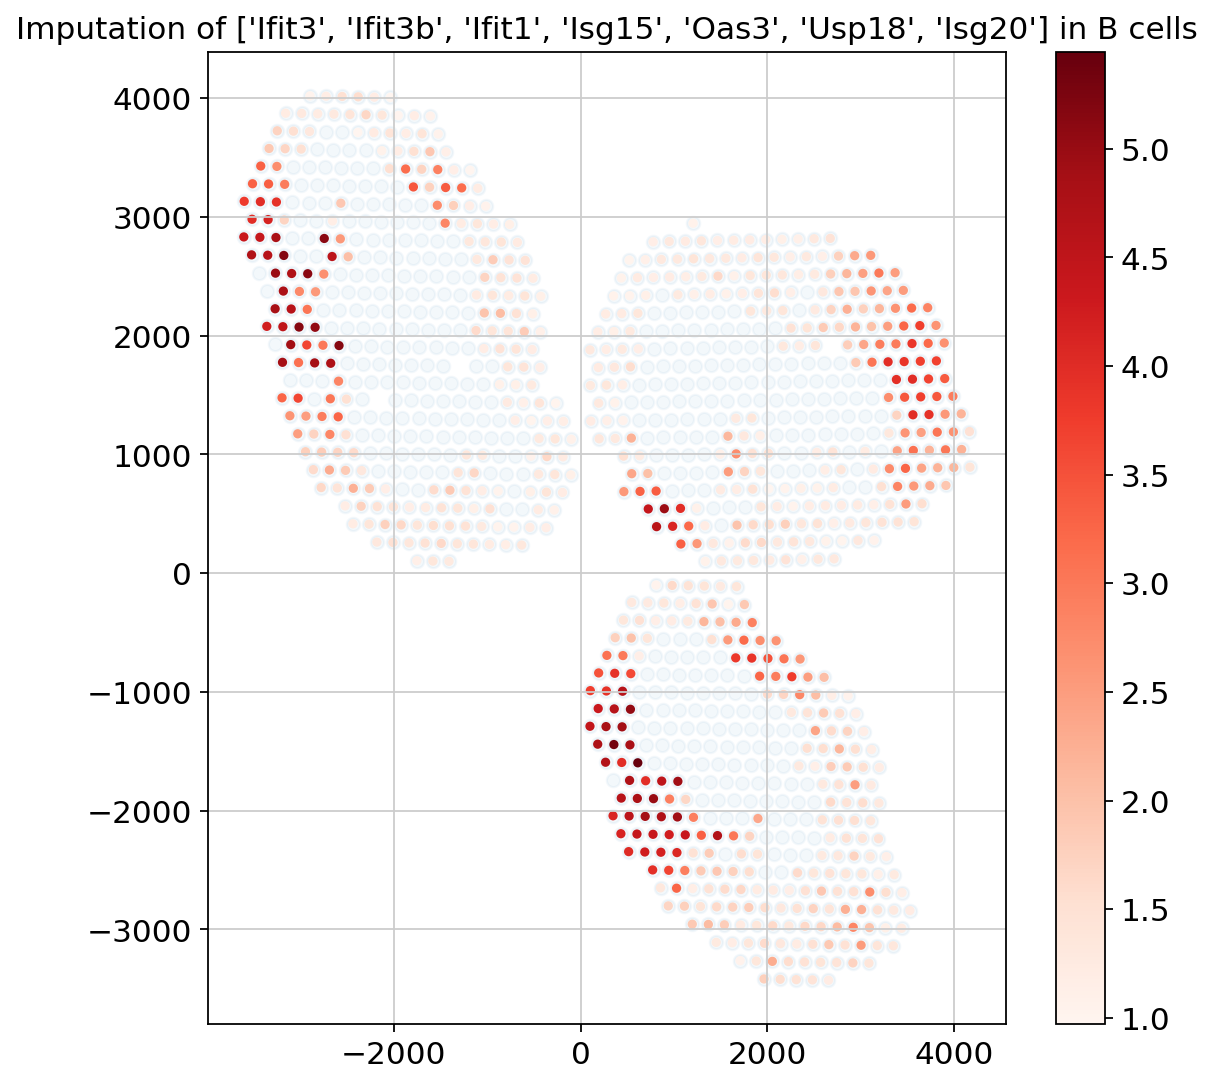

In [126]:
plt.figure(figsize=(8, 8))

ct_name = "B cells"
gene_name = ["Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"]

# we must filter spots with low abundance (consult the paper for an automatic procedure)
indices = np.where(st_adata.obsm["proportions"][ct_name].values > 0.2)[0]

# impute genes and combine them
specific_expression = np.sum(st_model.get_scale_for_ct(ct_name, indices=indices)[gene_name], 1)
specific_expression = np.log(1 + 1e4 * specific_expression)

# plot (i) background (ii) g
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(st_adata.obsm["location"][indices][:, 0], st_adata.obsm["location"][indices][:, 1], 
            c=specific_expression, s=10, cmap="Reds")
plt.colorbar()
plt.title(f"Imputation of {gene_name} in {ct_name}")
plt.show()

Third, we apply a Kolmogorov-Smirnov test on the generated counts to study the differential expression of B cells in the exposed lymph nodes, between the interfollicular area (IFA) and the rest. We display the identified IFN genes in a Volcano plot and see significant upregulation in the IFA area of exposed lymph nodes.

,log2FC,score,pval
Irf7,2.487860,0.928040,0.0
Zbp1,1.845941,0.922783,0.0
Trim30a,1.737667,0.920923,0.0
Trafd1,1.366087,0.909647,0.0
Rnf213,1.873641,0.906471,0.0
Parp14,1.694875,0.898765,0.0
Usp18,2.121491,0.891048,0.0
Ifit3,2.828886,0.888768,0.0
Rtp4,1.778932,0.886786,0.0
Oasl2,1.625090,0.882381,0.0


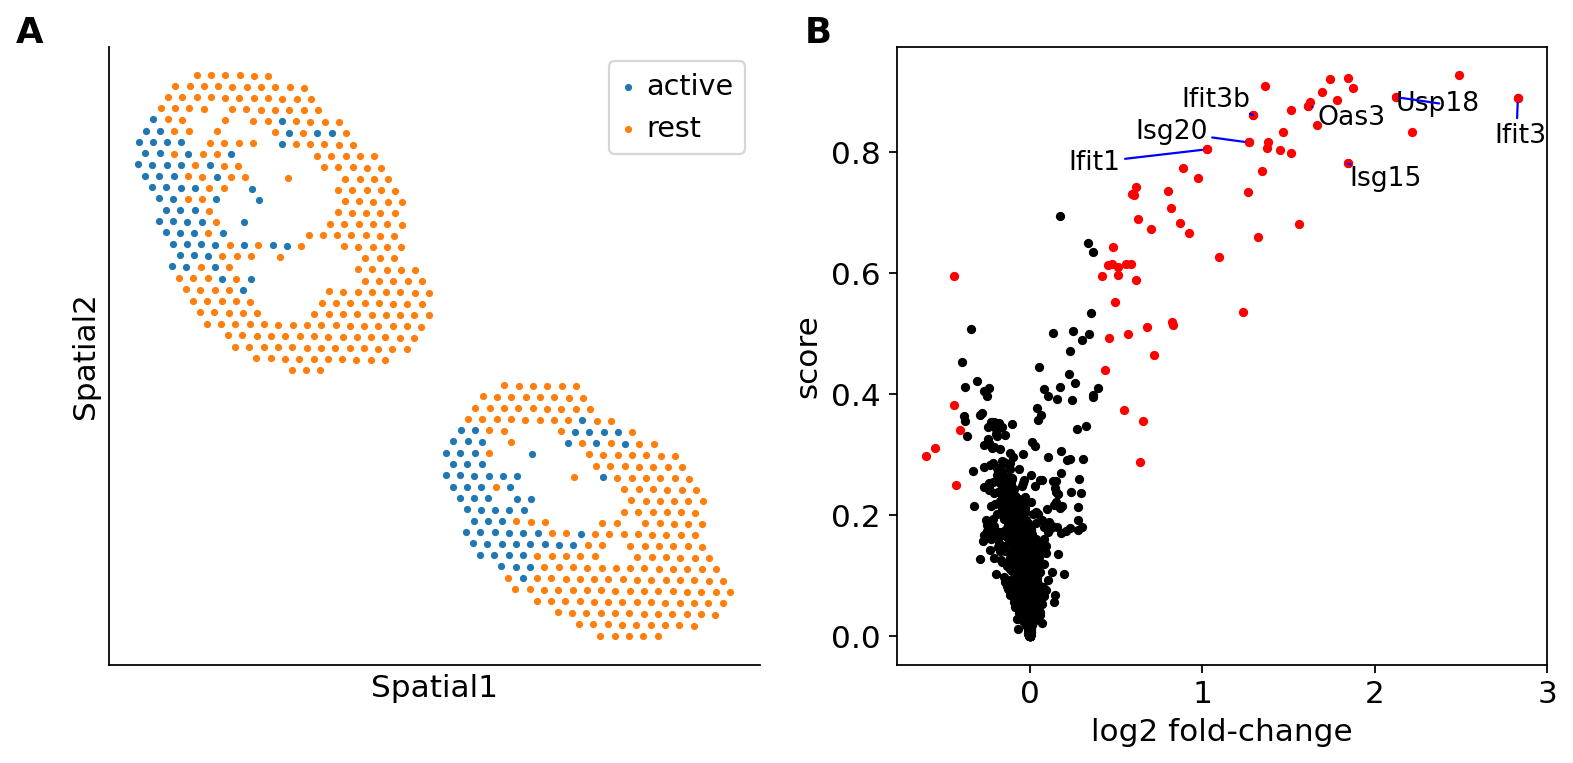

In [127]:
ct = 'B cells'
imputation = st_model.get_scale_for_ct(ct)
color = np.log(1 + 1e5 * imputation["Ifit3"].values)
threshold = 4

mask = np.logical_and(
    np.logical_or(st_adata.obs['LN'] == "TC", st_adata.obs['LN'] == "BD"),
    color > threshold).values

mask2 = np.logical_and(
    np.logical_or(st_adata.obs['LN'] == "TC", st_adata.obs['LN'] == "BD"),
    color < threshold).values

_ = destvi_utils.de_genes(
    st_model, mask=mask, mask2=mask2, threshold=ct_thresholds[ct], ct=ct, key='IFN_rich')

display(st_adata.uns['IFN_rich']['de_results'].head(10))

destvi_utils.plot_de_genes(st_adata, interesting_genes=[
  "Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"], key='IFN_rich')